# Lecture 12 : Priority Queues

In [1]:
# clone a public repo on Github to download some data files
!git clone https://github.com/jasonrwilson/cmda3634_materials.git

Cloning into 'cmda3634_materials'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 170 (delta 32), reused 66 (delta 32), pack-reused 103
Receiving objects: 100% (170/170), 35.38 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [2]:
# copy the lecture 12 files to our working directory
!cp cmda3634_materials/L12/* .

# Part 1 : Motivation

## In a previous assignment you found the three smallest numbers in a file as well as the three numbers closest to a given number.  

## Suppose we want to find the k smallest numbers in a file or the k numbers closest to a given number.  

## An example application would be to find the $k^{th}$ order statistic of a dataset.  

## More generally, we may want to find the k datapoints in $\mathbb{R}^{dim}$ closest to a given datapoint.

## An example application would be **k-nearest neighbors classification**.  

## For knn classification, we classify a test point based on the classes of the majority of the k-nearest neighbors from the training set.

## For these applications and others it is helpful to use a data structure called a **priority queue**.

## Each element in a priority queue has an associated priority. In a priority queue, elements with high priority are served before elements with low priority.

# Part 2 : Priority Queue Interface

## We start with our priority queue interface which we put into the *pri_queue.h* header file.

In [3]:
%%writefile pri_queue.h
#ifndef PRI_QUEUE_H
#define PRI_QUEUE_H

typedef struct pri_queue_element_s {
    double priority;
    int id;
} pri_queue_element;

typedef struct pri_queue_s {
    pri_queue_element* elements;
    int max_size;
    int cur_size;
} pri_queue;

void pri_queue_init(pri_queue* pq, int max_size);

pri_queue_element pri_queue_peek_top(pri_queue* pq);

void pri_queue_delete_top(pri_queue* pq);

void pri_queue_insert(pri_queue* pq, pri_queue_element element);

void pri_queue_free(pri_queue* pq);

#endif

Writing pri_queue.h


## Note that our priority queue interface uses two C structures.

## The first C structure *pri_queue_element* specifies the **priority** and **id** of an element on the priority queue.  

## The *priority* is a double and the *id* is an integer.  

## The element with the highest priority will be at the top of the priority queue.  

## The *id* allows the user of the priority queue to identify the element with that given priority.  Frequently the *id* is the index of the element in an array containing all of the elements in a dataset.

## The second C structure **pri_queue** is for the priority queue itself.  Note that there will be an array of priority queue elements but only a pointer to the array is specified in the structure.  This means that the array will have to be dynamically allocated using **malloc**.  Note that the priority queue has a **max_size** which will be specified by the user as well as a **cur_size** which is initially equal to zero.

## The first function of the priority queue *pri_queue_init* is for initialization.  In object oriented programming language this function is similar to a **constructor**.  The implementation of this method will have to dynamically allocate space to store the priority queue.  We provide another function *pri_queue_free* which will free up the dynamically allocated memory.

## The *pri_queue_peek_top* function allows the user to look at the element in the priority queue with the highest priority **without removing it**.  It will raise an error and terminate the program if the priority queue is empty.

## The *pri_queue_delete_top* function deletes the element in the priority queue with the highest priority.  It will raise an error and terminate the program if the priority queue is empty.  

## Finally, the *pri_queue_insert* function inserts the given element into the priority queue.  It will raise an error and terminate the program if the priority queue is already full.  

# Part 3 : First Priority Queue Implementation

## For our first priority queue implementation we will store the elements in the priority queue in sorted order according to priority with the lowest priority element stored at the beginning of the array and the highest priority element stored at the end of the array.

## With this implementation all functions except *pri_queue_insert* are fast and straightforward.

## For the *pri_queue_insert* function we maintain order while inserting using the following two steps:

* Find the correct place for the new element in the sorted array while simultaneously moving all elements in the array with a priority higher than the new element to the right one position to make room for the new element.  

* Insert the new element in the correct place.

## In the worst case the insert function will have to move all elements!  

## Later we will implement the priority queue more efficiently using a max heap.

In [4]:
%%writefile pri_queue.c
#include <stdio.h>
#include <stdlib.h>
#include "pri_queue.h"

void pri_queue_init(pri_queue* pq, int max_size) {
    pq->elements = (pri_queue_element*)malloc(max_size*sizeof(pri_queue_element));
    if (pq->elements == NULL) {
        printf ("error : malloc failed in pri_queue_init\n");
        exit(1);
    }
    pq->max_size = max_size;
    pq->cur_size = 0;
}

pri_queue_element pri_queue_peek_top(pri_queue* pq) {
    if (pq->cur_size == 0) {
        printf ("error : underflow in pri_queue_peek_top\n");
        exit(1);
    }
    return pq->elements[pq->cur_size-1];
}

void pri_queue_delete_top(pri_queue* pq) {
    if (pq->cur_size == 0) {
        printf ("error : underflow in pri_queue_delete_top\n");
        exit(1);
    }
    pq->cur_size -= 1;
}

void pri_queue_insert(pri_queue* pq, pri_queue_element element) {
    if (pq->cur_size >= pq->max_size) {
        printf ("error : overflow in pri_queue_insert\n");
        exit(1);
    }

    // find the correct place for the new element
    // while simultaneously moving existing elements with
    // higher priority to the right one space
    int place = pq->cur_size;
    while (place > 0) {
        if (element.priority >= pq->elements[place-1].priority) {
            break;
        }
        // make space for the new element
        pq->elements[place] = pq->elements[place-1];
        place -= 1;
    }

    // insert the new element
    pq->elements[place] = element;
    pq->cur_size += 1;
}

void pri_queue_free(pri_queue* pq) {
    if (pq->elements == 0) {
        printf ("error : null elements pointer in pri_queue_free\n");
        exit(1);
    }
    free (pq->elements);
    pq->elements = 0;
}

Writing pri_queue.c


# Part 4 : Insertion Sort

## As a first application of our priority queue let's sort an input file of numbers from largest to smallest.  Given our current implementation of the priority queue, this is an **insertion sort**.  

In [5]:
%%writefile largest_first.c
#include <stdio.h>
#include "pri_queue.h"

int main () {

    /* read the number of entries in the file */
    int num;
    if (scanf("%*c %d",&num) != 1) {
        printf ("error reading the number of entries!\n");
        return 1;
    }

    /* initialize the priority queue */
    pri_queue pq;
    pri_queue_init (&pq,num);

    /* read entries from stdin and add them to the priority queue */
    pri_queue_element next;
    for (int i=0;i<num;i++) {
        if (scanf("%lf",&(next.priority)) != 1) {
            printf ("error : file too small\n");
            return 1;
        }
        pri_queue_insert (&pq,next);
    }

    /* print the entries from largest to smallest */
    while (pq.cur_size > 0) {
        next = pri_queue_peek_top(&pq);
        printf ("%g\n",next.priority);
        pri_queue_delete_top(&pq);
    }

    /* free the priority queue */
    pri_queue_free (&pq);
}

Writing largest_first.c


In [6]:
!gcc -o largest_first largest_first.c pri_queue.c

In [7]:
!echo \# 5 1.2 -2.4 3.2 -3.5 2.6 | ./largest_first

3.2
2.6
1.2
-2.4
-3.5


## We can sort from smallest to largest by negating the priorities.

In [8]:
%%writefile sort.c
#include <stdio.h>
#include "pri_queue.h"

int main () {

    /* read the number of entries in the file */
    int num;
    if (scanf("%*c %d",&num) != 1) {
        printf ("error reading the number of entries!\n");
        return 1;
    }

    /* initialize the priority queue */
    pri_queue pq;
    pri_queue_init (&pq,num);

    /* read entries from stdin and add them to the priority queue */
    pri_queue_element next;
    for (int i=0;i<num;i++) {
        if (scanf("%lf",&(next.priority)) != 1) {
            printf ("error : file too small\n");
            return 1;
        }
        next.priority *= -1.0;
        pri_queue_insert (&pq,next);
    }

    /* print the entries from largest to smallest */
    while (pq.cur_size > 0) {
        next = pri_queue_peek_top(&pq);
        printf ("%g\n",-1.0*next.priority);
        pri_queue_delete_top(&pq);
    }

    /* free the priority queue */
    pri_queue_free (&pq);
}

Writing sort.c


In [9]:
!gcc -o insertion_sort sort.c pri_queue.c

In [10]:
!echo \# 5 1.2 -2.4 3.2 -3.5 2.6 | ./insertion_sort

-3.5
-2.4
1.2
2.6
3.2


In [11]:
!time cat num100k.txt | ./insertion_sort > sorted100k.txt


real	0m10.462s
user	0m10.284s
sys	0m0.021s


In [12]:
!head -10 sorted100k.txt

0
1
2
3
4
5
6
7
8
9


## It takes around 10.5 seconds to sort 100000 numbers.  About how long will it take insertion sort to sort 1000000 numbers?

## Answer: Since insertion sort is O(n^2) multiplying the problem size by 10 multiples the runtime by 100.  Thus it should take roughly 10.5*100 = 1050 seconds or around 17.5 minutes.  

In [13]:
!time cat num1m.txt | ./insertion_sort > insertion_sorted1m.txt


real	19m47.019s
user	19m33.447s
sys	0m0.552s


# Part 5 : Heap Sort

## In a separate part of this lecture you learned about max heaps.  

## In the following implementation of a priority queue we use a max heap.  

## Note that both insertion and deletion now take $O(\log n)$ time in the worst case

In [14]:
%%writefile pri_queue_heap.c
#include <stdio.h>
#include <stdlib.h>
#include "pri_queue.h"

void pri_queue_init(pri_queue* pq, int max_size) {
    pq->elements = (pri_queue_element*)malloc(max_size*sizeof(pri_queue_element));
    if (pq->elements == 0) {
        printf ("error : malloc failed in pri_queue_init\n");
        exit(1);
    }
    pq->max_size = max_size;
    pq->cur_size = 0;
}

pri_queue_element pri_queue_peek_top(pri_queue* pq) {
    if (pq->cur_size == 0) {
        printf ("error : underflow in pri_queue_peek_top\n");
        exit(1);
    }
    return pq->elements[0];
}

void pri_queue_delete_top(pri_queue* pq) {

    // check for an empty priority queue
    if (pq->cur_size == 0) {
        printf ("error : underflow in pri_queue_delete_top\n");
        exit(1);
    }

    // move the last element to the root and decrease size by 1
    pq->elements[0] = pq->elements[pq->cur_size-1];
    pq->cur_size -= 1;

    // start at the root
    int current = 0;

    // descend the tree swapping as necessary to maintain maxheap property
    while (current*2+1<pq->cur_size) {
        // first consider the left child
        int child = current*2+1;
        // handle the case where the right child has higher priority
        if ((child+1<pq->cur_size) &&
                (pq->elements[child+1].priority > pq->elements[child].priority)) {
            child = child + 1;
        }
        // check to see if we should swap current and child
        if (pq->elements[current].priority < pq->elements[child].priority) {
            pri_queue_element temp = pq->elements[current];
            pq->elements[current] = pq->elements[child];
            pq->elements[child] = temp;
        } else {
            // done if largest child value is less than or equal to ours
            break;
        }
        // descend the tree
        current = child;
    }
}

void pri_queue_insert(pri_queue* pq, pri_queue_element element) {

    // check to see if there is room for the new element
    if (pq->cur_size == pq->max_size) {
        printf("error : overflow in pri_queue_insert!\n");
        exit (1);
    }

    // set the current index
    int current = pq->cur_size;

    // insert at the end
    pq->elements[current] = element;
    pq->cur_size += 1;

    // climb the tree swapping as necessary to maintain maxheap property
    while (current > 0) {
        int parent = (current-1)/2;
        // check to see if we need to swap value with parent
        if (pq->elements[parent].priority < pq->elements[current].priority) {
            pri_queue_element temp = pq->elements[current];
            pq->elements[current] = pq->elements[parent];
            pq->elements[parent] = temp;
        } else {
            // done if parent value is greater than or equal to current
            break;
        }
        // climb the tree
        current = parent;
    }
}

void pri_queue_free(pri_queue* pq) {
    if (pq->elements == 0) {
        printf ("error : null elements pointer in pri_queue_free\n");
        exit(1);
    }
    free (pq->elements);
    pq->elements = 0;
}

Writing pri_queue_heap.c


In [15]:
!gcc -o heap_sort sort.c pri_queue_heap.c

In [16]:
!time cat num1m.txt | ./heap_sort > heap_sorted1m.txt


real	0m1.751s
user	0m1.667s
sys	0m0.066s


In [17]:
!diff insertion_sorted1m.txt heap_sorted1m.txt

# Part 6 : k-Nearest Neighbors

## For the final part of this lecture let's use our heap based priority queue to find the k nearest neighbors to a point in a dataset where the points are in $\mathbb{R}^{dim}$.

## The number k and the index of the point to the find the k nearest neighbors of are command line arguments.

In [18]:
%%writefile knn.c
#include <stdio.h>
#include <stdlib.h>
#include "vec.h"
#include "pri_queue.h"

int main (int argc, char* argv[]) {

    // read the command line arguments
    if (argc < 3) {
        printf ("command usage: %s %s %s\n",argv[0],"k","index");
        return 1;
    }
    int k = atoi(argv[1]);
    int index = atoi(argv[2]);

    // read the number of points and the dimension of each point
    int num_points, dim;
    if (scanf("%*c %d %d",&num_points, &dim) != 2) {
        printf ("error reading the number of points and the dimension\n");
        return 1;
    }

    // Read vectors from stdin and store them in a flat 2d array
    double* data = (double*)malloc(num_points*dim*sizeof(double));
    if (data == NULL) {
        printf ("failed to allocate data array!\n");
        return 1;
    }
    for (int i=0;i<num_points;i++) {
        // data+i*dim is a pointer to the ith data point
        if (vec_read_stdin(data+i*dim,dim) != dim) {
            printf ("error reading the next point from stdin\n");
            return 1;
        }
    }

    // initialize the priority queue
    pri_queue pq;
    pri_queue_init (&pq,k);

    // calculate all distances squared
    // and store the indices of the k nearest in the priority queue
    for (int i=0;i<num_points;i++) {
        double dist_sq = vec_dist_sq(data+i*dim,data+index*dim,dim);
        pri_queue_element new = { dist_sq, i };
        if (pq.cur_size < k) {
            pri_queue_insert(&pq, new);
        } else {
            pri_queue_element top = pri_queue_peek_top(&pq);
            if (dist_sq < top.priority) {
                pri_queue_delete_top(&pq);
                pri_queue_insert(&pq,new);
            }
        }
    }

    // remove the k nearest indices from the priority queue
    int nearest[k];
    for (int i=k-1;i>=0;i--) {
        pri_queue_element top = pri_queue_peek_top(&pq);
        nearest[i] = top.id;
        pri_queue_delete_top(&pq);
    }

    // print the k nearest indices from closest to farthest
    printf ("k nearest neighbors: ");
    for (int i=0;i<k;i++) {
        printf ("%d ",nearest[i]);
    }
    printf ("\n");

    // free the priority queue */
    pri_queue_free (&pq);

    // free our heap array
    free (data);
}


Writing knn.c


In [19]:
!gcc -o knn knn.c pri_queue_heap.c vec.c

In [20]:
!echo \# 3 2 1 1 2 2 4 4 | ./knn 3 1

k nearest neighbors: 1 0 2 


## Let's look at the 16 numbers closest to the test image with index 11.  Note that the upper left image in the 4 x 4 grid is test image 11.  The closest images are arranged in row-major order (e.g. test image 11 and its 3 nearest neighbors occupy the first row of the 4x4 grid and so on).

In [21]:
!cat mnist_test.txt | ./knn 16 11

k nearest neighbors: 11 4686 3901 973 4449 3827 1977 4051 1332 4831 7705 8579 8564 2039 2286 6406 


In [22]:
!cat mnist_test.txt | python3 mnist16.py mnist_test_11_16.png 11 4686 3901 973 4449 3827 1977 4051 1332 4831 7705 8579 8564 2039 2286 6406

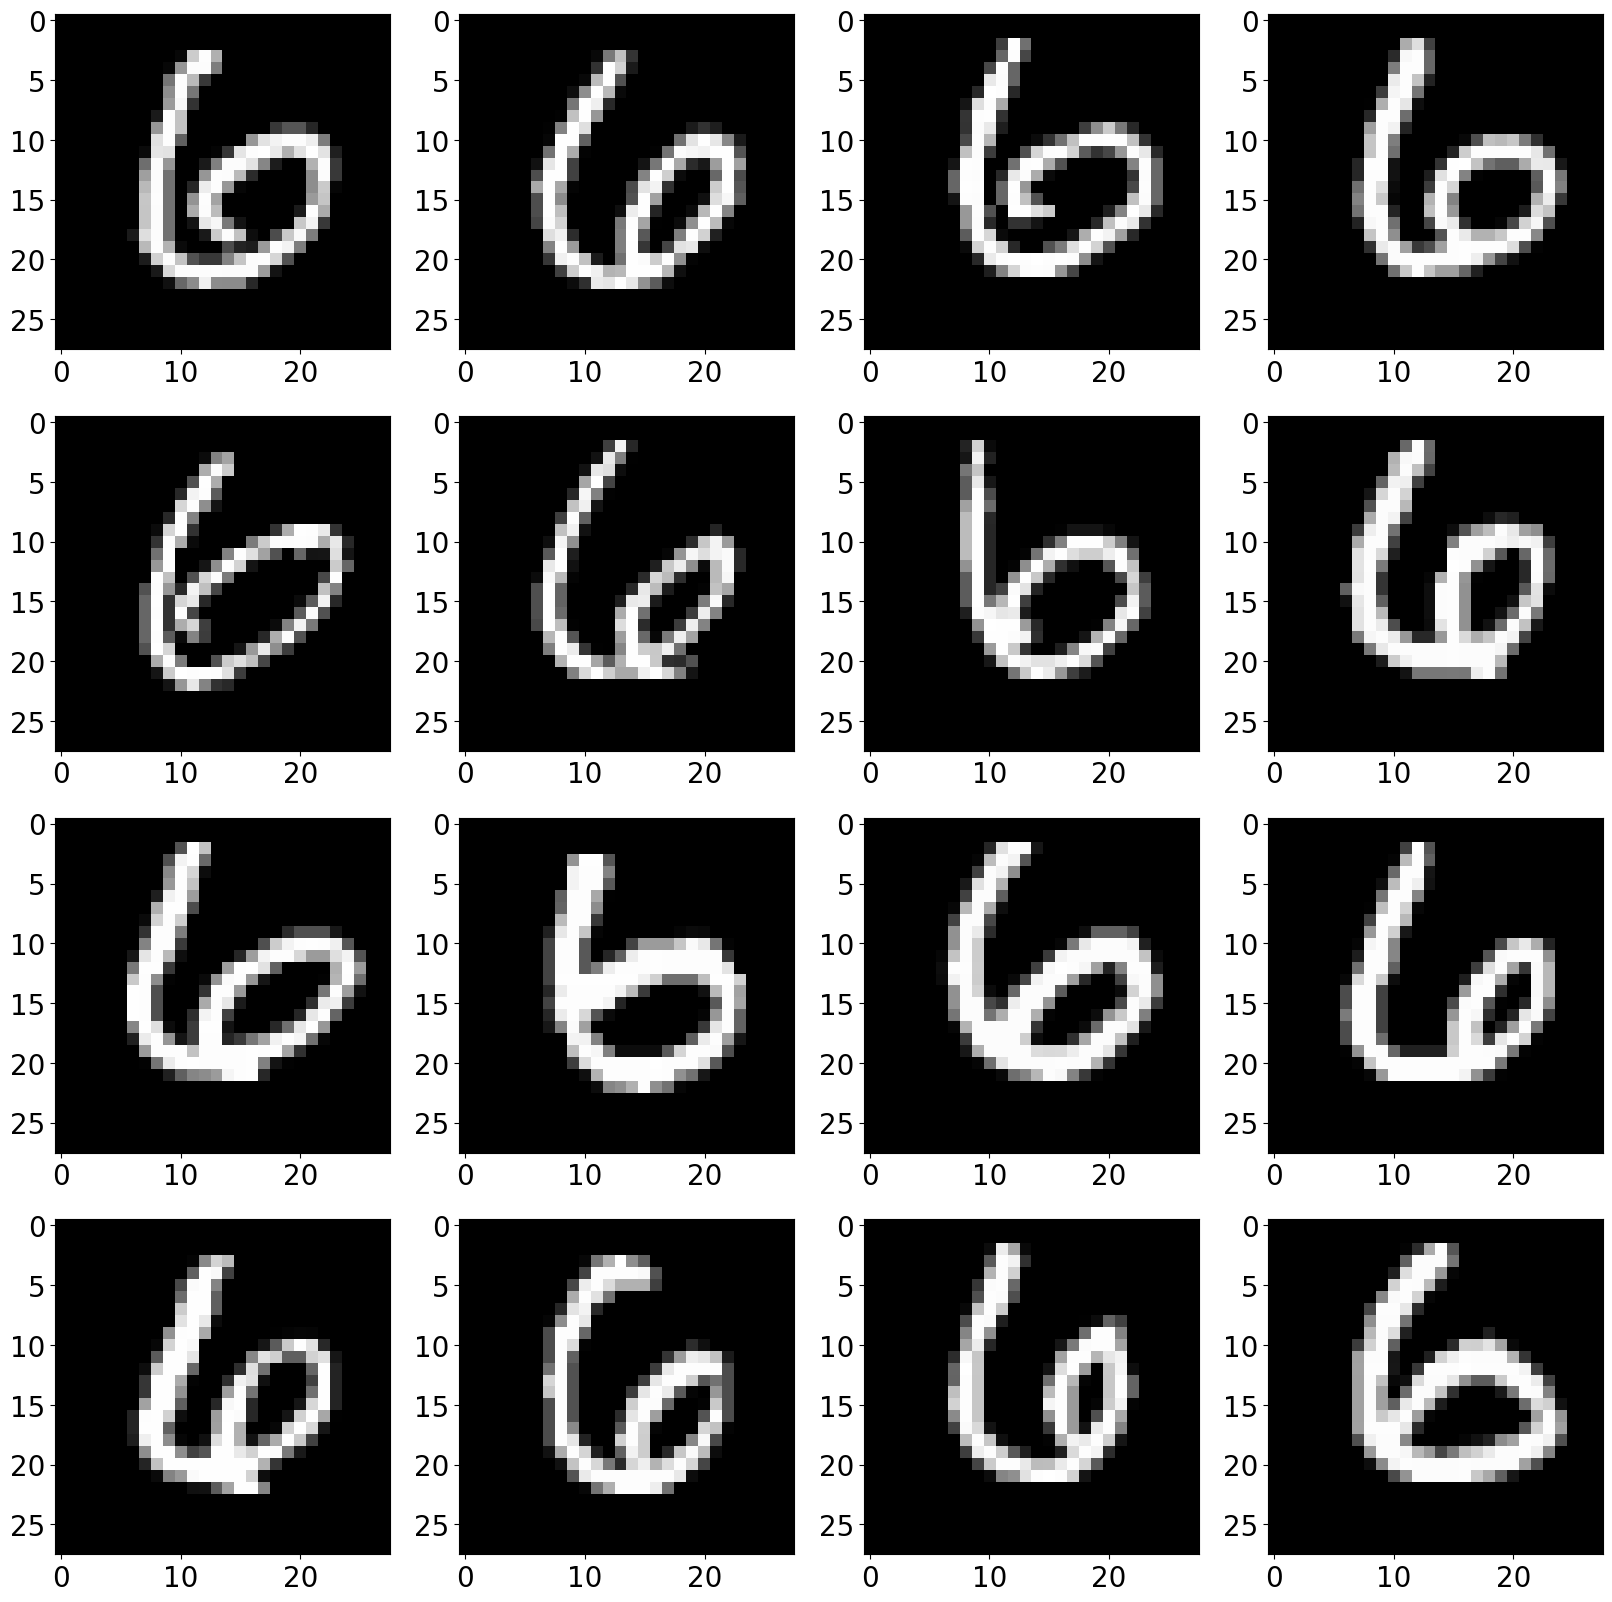

In [23]:
from PIL import Image, ImageOps # for image processing
sixes = Image.open("mnist_test_11_16.png")
sixes